<a href="https://colab.research.google.com/github/MahparaBadar/Deep-Learning/blob/main/MIDTERM_EXAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MCQs

# 1- Which of the following activation functions can lead to vanishing gradients?
# (iv) Sigmoid

# 2- After training a neural network, you observe a large gap between the training accuracy (100%) and
# the test accuracy (42%). Which of the following methods is commonly used to reduce this gap?

# (ii) Dropout

# 3- Which of the following is true about Batch normalization?
# (ii) Batch norm makes training faster.

# 4- Which of the following propositions are true about a CONV layer? (Check all that apply.)
# (i) The number of weights depends on the depth of the input volume.
# (ii) The number of biases is equal to the number of filters.

# 5- What is Error Analysis?
# (ii) The process of scanning mis-classified examples to identify weaknesses of a model.

In [2]:
# TASK 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , InputLayer , Conv2D , MaxPooling2D , Dropout , Flatten , Input,concatenate,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121 , ResNet50

In [4]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 75% 45.0M/60.3M [00:00<00:00, 239MB/s]
100% 60.3M/60.3M [00:00<00:00, 239MB/s]


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'

)

val_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : angry
1 : disgust
2 : fear
3 : happy
4 : neutral
5 : sad
6 : surprise


In [8]:
train_class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))

print("Number of samples in each class (Training set):")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")


val_class_counts = dict(zip(val_generator.class_indices.keys(), np.bincount(val_generator.classes)))

print("\nNumber of samples in each class (Validation set):")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")


test_class_counts = dict(zip(test_generator.class_indices.keys(), np.bincount(test_generator.classes)))

print("\nNumber of samples in each class (Test set):")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Number of samples in each class (Training set):
angry: 3196
disgust: 349
fear: 3278
happy: 5772
neutral: 3972
sad: 3864
surprise: 2537

Number of samples in each class (Validation set):
angry: 799
disgust: 87
fear: 819
happy: 1443
neutral: 993
sad: 966
surprise: 634

Number of samples in each class (Test set):
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


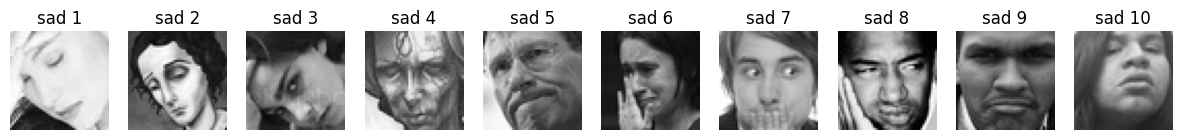

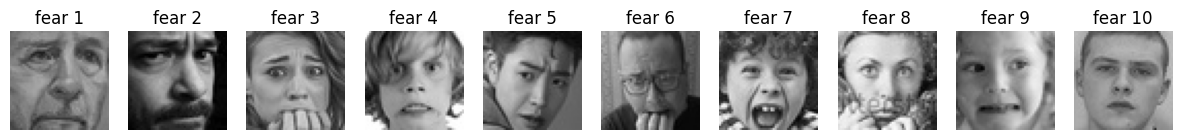

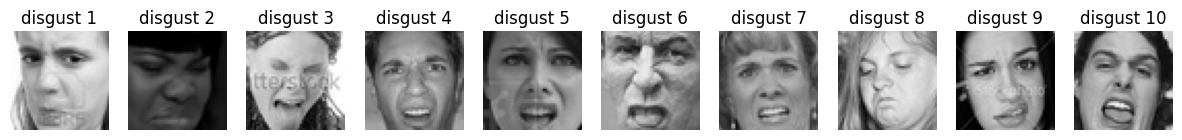

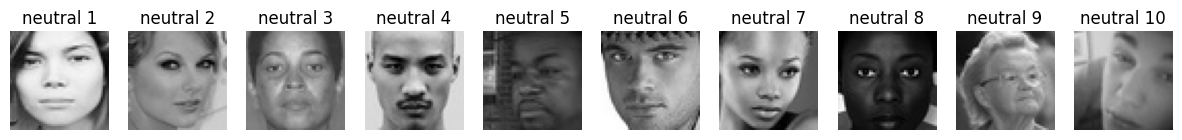

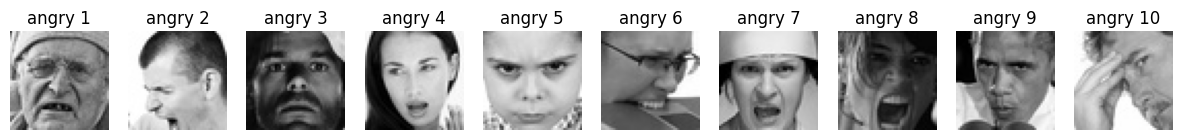

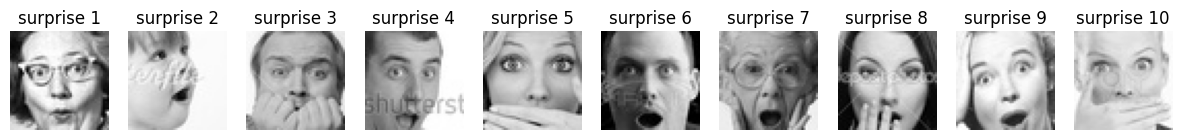

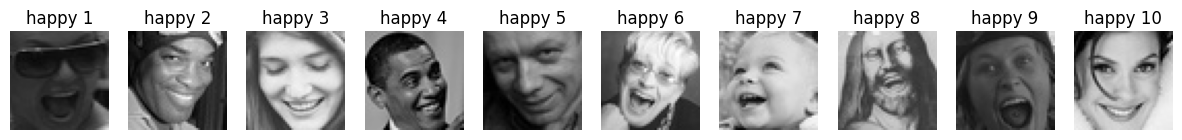

In [9]:
def display_images_by_class(parent_folder, n_images=10):
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(48, 48))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

parent_folder = 'train'

display_images_by_class(parent_folder, n_images=10)

In [10]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [11]:
class StandardizedConv2DWithOverride(Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )

In [12]:
# Inputs
input_layer = Input((48,48,3))

# Encoder
f1=StandardizedConv2DWithOverride(32, kernel_size=3, strides=3, padding='same', activation='relu')(input_layer)
f1=BatchNormalization()(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f2=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1])
f=BatchNormalization()(f)

f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu',name='BeforeFinal_Layer')(f)
f=MaxPooling2D(2,2)(f)
f3=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1,f2])
f=BatchNormalization()(f)

f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f4=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)

f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f3])

f1=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f4])
#f=BatchNormalization()(f)
f=Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu', name='Final_Layer')(f)
#f=Conv2D(512, kernel_size=1, strides=2, padding='same', activation='relu')(f)
f=BatchNormalization()(f)

f= Flatten()(f)
f=Dropout(rate=0.3)(f)
#f=BatchNormalization()(f)
f=Dense(1024, activation='relu')(f)
f=Dropout(rate=0.32)(f)
#f=BatchNormalization()(f)
output_layer=Dense(7, activation='softmax')(f)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ standardized_conv2d_with… │ (None, 16, 16, 32)     │            896 │ input_layer[0][0]      │
│ (StandardizedConv2DWithO… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 32)     │            128 │ standardized_conv2d_w… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 8, 8, 32)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 32)       │          9,248 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 64)       │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BeforeFinal_Layer         │ (None, 8, 8, 64)       │         36,928 │ conv2d_6[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 4, 4, 64)       │              0 │ BeforeFinal_Layer[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 4, 4, 64)       │         36,928 │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 6,188,135 (23.61 MB)

 Trainable params: 6,185,831 (23.60 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
ES = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
history = model.fit(train_generator,epochs=100,validation_data=val_generator,batch_size = 32, callbacks=[ES,RL],class_weight=class_weights)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.1349 - loss: 0.4868 - val_accuracy: 0.1749 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - accuracy: 0.1363 - loss: 0.4294 - val_accuracy: 0.0152 - val_loss: 0.4132 - learning_rate: 0.0010
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.1199 - loss: 0.4223 - val_accuracy: 0.1341 - val_loss: 0.4103 - learning_rate: 0.0010
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 85s 62ms/step - accuracy: 0.1673 - loss: 0.4091 - val_accuracy: 0.0747 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.1980 - loss: 0.4014 - val_accuracy: 0.1258 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.2312 - loss: 0.3886 - val_accuracy: 0.1745 - val_loss: 0.3976 - learning_rate: 0.0010
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.2162 - loss: 

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
loss,acc = model.evaluate(train_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

In [ ]:
predictions = model.predict(test_generator)
#y_pred = (predictions > 0.5).astype(int)
y_pred = np.argmax(predictions,axis = 1)
y_true = test_generator.classes

In [ ]:
#predictions = predictions.reshape(1,-1)[0]
cf_mtx = confusion_matrix(y_true,y_pred)
print(cf_mtx)

In [ ]:
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

In [ ]:
def display_images_with_predictions(generator, y_pred, num_images_to_display=10):
    # Get the class labels
    labels = {v: k for k, v in generator.class_indices.items()}

    # Get the filenames of the images
    filenames = generator.filenames

    # Create a subplot grid
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

    for i in range(num_images_to_display):
        # Construct image path
        image_path = os.path.join(generator.directory, filenames[i])
        image = plt.imread(image_path)

        # Get predicted label
        predicted_label_idx = int(y_pred[i])
        predicted_label = labels[predicted_label_idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Call the function
display_images_with_predictions(train_generator, y_pred, num_images_to_display=10)

In [ ]:
# TASK 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_dir = pathlib.Path('/kaggle/input/fruits-dataset-images')
print(data_dir)
list(data_dir.glob('*/*'))[:10]

In [ ]:
data_dir = pathlib.Path('/kaggle/input/fruits-dataset-images/images/')
print(data_dir)
list(data_dir.glob('*/*'))[:5]

In [ ]:
mango = list(data_dir.glob('mango fruit/*'))
mango[:5]

In [ ]:
PIL.Image.open(str(mango[5]))

In [ ]:
kiwi = list(data_dir.glob('kiwi fruit/*'))
kiwi[:5]

In [ ]:
PIL.Image.open(str(kiwi[1]))

In [ ]:
fruit_images_dict = {
    'mango': list(data_dir.glob('mango fruit/*')),
    'kiwi': list(data_dir.glob('kiwi fruit/*')),
    'apple': list(data_dir.glob('apple fruit/*')),
    'banana': list(data_dir.glob('banana fruit/*')),
    'cherry': list(data_dir.glob('cherry fruit/*')),
    'chickoo': list(data_dir.glob('chickoo fruit/*')),
    'grapes': list(data_dir.glob('grapes fruit/*')),
    'orange': list(data_dir.glob('orange fruit/*')),
    'strawberry': list(data_dir.glob('strawberry fruit/*'))
}

fruit_labels_dict = {
    'mango': 0,
    'kiwi': 1,
    'apple': 2,
    'banana': 3,
    'cherry': 4,
    'chickoo': 5,
    'grapes': 6,
    'orange': 7,
    'strawberry': 8
}

In [ ]:
fruit_images_dict['mango'][:5]

In [ ]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_CHANNELS = 3
X, Y = [], []

for fruit_name, images in fruit_images_dict.items():
    print(fruit_name)
    for image in images:
        img = cv2.imread(str(image))
        if isinstance(img,type(None)):
            #print('image not found')
            continue

        elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
            resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
            X.append(resized_img)
            Y.append(fruit_labels_dict[fruit_name])
        else:
            #print("Invalid Image")
            continue

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.1)
print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
IMAGE_CHANNELS=3
model = Sequential([

Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Flatten(),
Dense(512, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(1, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
history=model.fit(X_train, Y_train, epochs=45)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = [0 if element < 0.5 else 1 for element in y_pred]

print("Classification Report: \n", classification_report(Y_test, y_pred_classes, zero_division=0))